In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
import awkward

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import (get_pu_weights_function,
                                          get_ttbar_weight,
                                          get_nlo_weight_function)

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
datasets_=json.load(open('../Samples/backgrounds_nonempty.json'))
scales_=json.load(open('../Samples/backgrounds_scale.json'))

# flatten datasets
datasets = {}
for group in datasets_:
    if group!='QCD': continue # study qcd
    for tag in datasets_[group]:
        if tag == 'QCD_Pt-470to600': continue # this dataset is mix
        datasets[tag] = datasets_[group][tag]

# flatten scales
scales = {}
for group in scales_:
    for tag in scales_[group]:
        scales[tag] = scales_[group][tag]

lumi = 59.74*1e3
for k in scales:
    scales[k] *= lumi

# mapping
mapping = {}
for k in datasets_: mapping[k] = list(datasets_[k])

In [20]:
class ak4chsprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        channel_axis = hist.Cat('channel', 'channel')
        pt_axis = hist.Bin('pt', 'pT [GeV]', 50, 0, 100)
        maxpt_axis = hist.Bin('maxpt', 'pT [GeV]', 50, 0, 250)
        multi_axis = hist.Bin('multi', 'multiplicity', 10, 0, 10)
        ht_axis = hist.Bin('ht', 'HT [GeV]', 50, 0, 1000)
        hadHt_axis = hist.Bin('hadht', 'hadronic HT [GeV]', 50, 0, 1000)
        chaHadHt_axis = hist.Bin('chahadht', 'charged hadronic HT [GeV]', 50, 0, 1000)
        hovere_axis = hist.Bin('hovere', 'Had/EM', 50, 0, 2)
        dist_axis = hist.Bin('dist', 'distance', 50, 0, 1)
        fraction_axis = hist.Bin('frac', 'fraction', 50, 0, 1)
        ljpt_axis = hist.Bin('pt', 'pT [GeV]', 50, 0, 1000)
        akchspt_axis = hist.Cat('minpt', 'min ak4chs $p_T$ cut@0')
        cut_axis = hist.Bin('cut', 'pass cut', 2, 0, 2)
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist('counts', dataset_axis, pt_axis, channel_axis),
            'maxpt': hist.Hist('Events', dataset_axis, maxpt_axis, channel_axis),
            'multi': hist.Hist('Events', dataset_axis, multi_axis, channel_axis),
            'ht': hist.Hist('Events', dataset_axis, ht_axis, channel_axis),
            'hadht': hist.Hist('Events', dataset_axis, hadHt_axis, channel_axis),
            'chahadht': hist.Hist('Events', dataset_axis, chaHadHt_axis, channel_axis),
            'hovere': hist.Hist('counts', dataset_axis, hovere_axis, channel_axis),
            'minhovere': hist.Hist('Events', dataset_axis, hovere_axis, channel_axis),
            'mindist': hist.Hist('Events', dataset_axis, dist_axis, channel_axis),
            'hadfrac': hist.Hist('Counts', dataset_axis, channel_axis, fraction_axis),
            'chadfrac': hist.Hist('Counts', dataset_axis, channel_axis, fraction_axis),
            'ljpt': hist.Hist('Counts', dataset_axis, channel_axis, ljpt_axis, akchspt_axis),
            'ak4chscut': hist.Hist('Events', dataset_axis, cut_axis, channel_axis, akchspt_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset=df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'].content,
                    py=df['gen_p4.fCoordinates.fY'].content,
                    pz=df['gen_p4.fCoordinates.fZ'].content,
                    energy=df['gen_p4.fCoordinates.fT'].content,
                    pid=df['gen_pid'].content,
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        ak4chs = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_p4'],
            px=df['akjet_p4.fCoordinates.fX'],
            py=df['akjet_p4.fCoordinates.fY'],
            pz=df['akjet_p4.fCoordinates.fZ'],
            energy=df['akjet_p4.fCoordinates.fT'],
            jetid=df['akjet_jetid'],
            hadfr=df['akjet_hadronEnergyFraction'],
            chadfr=df['akjet_chaHadEnergyFraction'],
        )
        ak4chs.add_attributes(hovere=ak4chs.hadfr/(1-ak4chs.hadfr),
                             chovere=ak4chs.chadfr/(1-ak4chs.hadfr))
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        if dileptonjets.size==0: return output
        leadinglj = dileptonjets[dileptonjets.pt.argmax()]
        subleadinglj = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        onemujets = dileptonjets.ismutype.sum()==1
        twomujets = dileptonjets.ismutype.sum()==2
        wgt = weight[twoleptonjets]
        fourMuChannel = twomujets&(leadinglj.ismutype.flatten())&(subleadinglj.ismutype.flatten())
        twoMuTwoEChannel = onemujets&(leadinglj.ismutype.flatten()|subleadinglj.ismutype.flatten())

        ak4chs = ak4chs[twoleptonjets]
        
        wgt_ = wgt[twoMuTwoEChannel]
        ljs_ = dileptonjets[twoMuTwoEChannel]
        ak4chs_ = ak4chs[twoMuTwoEChannel]
        if ak4chs_.size!=0:
            #cleanmask = ak4chs_.match(ljs_, deltaRCut=0.4)
            output['ljpt'].fill(dataset=dataset, pt=ljs_.pt.flatten(), weight=(wgt_*(ljs_.pt.ones_like())).flatten(), channel='2mu2e', minpt='none')
            jetid_ = (ak4chs_.jetid&(ak4chs_.pt>20.)&(np.abs(ak4chs_.eta)<2.4)).sum()<=1
            output['ljpt'].fill(dataset=dataset, pt=ljs_[jetid_].pt.flatten(), weight=(wgt_*(ljs_.pt.ones_like()))[jetid_].flatten(), channel='2mu2e', minpt='20 GeV')
            output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='2mu2e', minpt='20 GeV', weight=wgt_)
            jetid_ = (ak4chs_.jetid&(ak4chs_.pt>50.)&(np.abs(ak4chs_.eta)<2.4)).sum()<=1
            output['ljpt'].fill(dataset=dataset, pt=ljs_[jetid_].pt.flatten(), weight=(wgt_*(ljs_.pt.ones_like()))[jetid_].flatten(), channel='2mu2e', minpt='50 GeV')
            output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='2mu2e', minpt='50 GeV', weight=wgt_)
            jetid_ = (ak4chs_.jetid&(ak4chs_.pt>100.)&(np.abs(ak4chs_.eta)<2.4)).sum()<=1
            output['ljpt'].fill(dataset=dataset, pt=ljs_[jetid_].pt.flatten(), weight=(wgt_*(ljs_.pt.ones_like()))[jetid_].flatten(), channel='2mu2e', minpt='100 GeV')
            output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='2mu2e', minpt='100 GeV', weight=wgt_)
            
            ak4chs_ = ak4chs_[ak4chs_.jetid&(ak4chs_.pt>100.)&(np.abs(ak4chs_.eta)<2.4)]

            wgts_ = (ak4chs_.pt.ones_like()*wgt_).flatten()
            output['multi'].fill(dataset=dataset, multi=ak4chs_.counts, weight=wgt_, channel='2mu2e')
            output['pt'].fill(dataset=dataset, pt=ak4chs_.pt.flatten(), weight=wgts_, channel='2mu2e')
            threeakjets = ak4chs_[ak4chs_.counts>2]
            thirdptidx = threeakjets.pt.argsort()[:, 2:3]
            thirdpt = threeakjets.pt[thirdptidx]
            output['maxpt'].fill(dataset=dataset, maxpt=thirdpt.flatten(), weight=wgt_[ak4chs_.counts>2], channel='2mu2e')
            output['ht'].fill(dataset=dataset, ht=ak4chs_.p4.pt.sum(), weight=wgt_, channel='2mu2e')
            output['hadht'].fill(dataset=dataset, hadht=(ak4chs_.p4.pt*ak4chs_.hadfr).sum(), weight=wgt_, channel='2mu2e')
            output['chahadht'].fill(dataset=dataset, chahadht=(ak4chs_.p4.pt*ak4chs_.chadfr).sum(), weight=wgt_, channel='2mu2e')
            output['hovere'].fill(dataset=dataset, hovere=ak4chs_.hovere.flatten(), weight=wgts_, channel='2mu2e')
            output['minhovere'].fill(dataset=dataset, hovere=ak4chs_.hovere.min(), weight=wgt_, channel='2mu2e')
            output['hadfrac'].fill(dataset=dataset, frac=ak4chs_.hadfr.flatten(), weight=wgts_, channel='2mu2e')
            output['chadfrac'].fill(dataset=dataset, frac=ak4chs_.chadfr.flatten(), weight=wgts_, channel='2mu2e')
        
#         filteredak4 = ak4chs[(ak4chs.pt>20)&(ak4chs.chovere>1)]
#         ljXak4chs = leptonjets.cross(filteredak4)
#         mindist = ljXak4chs.i0.p4.delta_r(ljXak4chs.i1.p4).min()
#         output['mindist'].fill(dataset=dataset, dist=mindist, weight=weight)
        
        wgt_ = wgt[fourMuChannel]
        ljs_ = dileptonjets[fourMuChannel]
        ak4chs_ = ak4chs[fourMuChannel]
        if ak4chs_.size!=0:
            cleanmask = ak4chs_.match(ljs_, deltaRCut=0.4)
            output['ljpt'].fill(dataset=dataset, pt=ljs_.pt.flatten(), weight=(wgt_*(ljs_.pt.ones_like())).flatten(), channel='4mu', minpt='none')
            jetid_ = (ak4chs_.jetid&(ak4chs_.pt>20.)&(np.abs(ak4chs_.eta)<2.4)).sum()==0
            output['ljpt'].fill(dataset=dataset, pt=ljs_[jetid_].pt.flatten(), weight=(wgt_*(ljs_.pt.ones_like()))[jetid_].flatten(), channel='4mu', minpt='20 GeV')
            output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='4mu', minpt='20 GeV', weight=wgt_)
            jetid_ = (ak4chs_.jetid&(ak4chs_.pt>50.)&(np.abs(ak4chs_.eta)<2.4)).sum()==0
            output['ljpt'].fill(dataset=dataset, pt=ljs_[jetid_].pt.flatten(), weight=(wgt_*(ljs_.pt.ones_like()))[jetid_].flatten(), channel='4mu', minpt='50 GeV')
            output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='4mu', minpt='50 GeV', weight=wgt_)
            jetid_ = (ak4chs_.jetid&(ak4chs_.pt>100.)&(np.abs(ak4chs_.eta)<2.4)).sum()==0
            output['ljpt'].fill(dataset=dataset, pt=ljs_[jetid_].pt.flatten(), weight=(wgt_*(ljs_.pt.ones_like()))[jetid_].flatten(), channel='4mu', minpt='100 GeV')
            output['ak4chscut'].fill(dataset=dataset, cut=jetid_.astype(int), channel='4mu', minpt='100 GeV', weight=wgt_)
            
            ak4chs_ = ak4chs_[ak4chs_.jetid&(ak4chs_.pt>100.)&(np.abs(ak4chs_.eta)<2.4)]

            wgts_ = (ak4chs_.pt.ones_like()*wgt_).flatten()
            output['multi'].fill(dataset=dataset, multi=ak4chs_.counts, weight=wgt_, channel='4mu')
            output['pt'].fill(dataset=dataset, pt=ak4chs_.pt.flatten(), weight=wgts_, channel='4mu')
            threeakjets = ak4chs_[ak4chs_.counts>2]
            thirdptidx = threeakjets.pt.argsort()[:, 2:3]
            thirdpt = threeakjets.pt[thirdptidx]
            output['maxpt'].fill(dataset=dataset, maxpt=thirdpt.flatten(), weight=wgt_[ak4chs_.counts>2], channel='4mu')
            output['ht'].fill(dataset=dataset, ht=ak4chs_.p4.pt.sum(), weight=wgt_, channel='4mu')
            output['hadht'].fill(dataset=dataset, hadht=(ak4chs_.p4.pt*ak4chs_.hadfr).sum(), weight=wgt_, channel='4mu')
            output['chahadht'].fill(dataset=dataset, chahadht=(ak4chs_.p4.pt*ak4chs_.chadfr).sum(), weight=wgt_, channel='4mu')
            output['hovere'].fill(dataset=dataset, hovere=ak4chs_.hovere.flatten(), weight=wgts_, channel='4mu')
            output['minhovere'].fill(dataset=dataset, hovere=ak4chs_.hovere.min(), weight=wgt_, channel='4mu')
            output['hadfrac'].fill(dataset=dataset, frac=ak4chs_.hadfr.flatten(), weight=wgts_, channel='4mu')
            output['chadfrac'].fill(dataset=dataset, frac=ak4chs_.chadfr.flatten(), weight=wgts_, channel='4mu')
            

        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        for k in origidentity:
            if not isinstance(accumulator[k], hist.Hist): continue
            accumulator[k].scale(scales, axis='dataset') # scale
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping) # cat grouping
        return accumulator

In [21]:
output = processor.run_uproot_job(datasets,
                                  treename="ffNtuplizer/ffNtuple",
                                  processor_instance=ak4chsprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 936/936 [02:34<00:00,  6.07items/s]


- 4mu channel

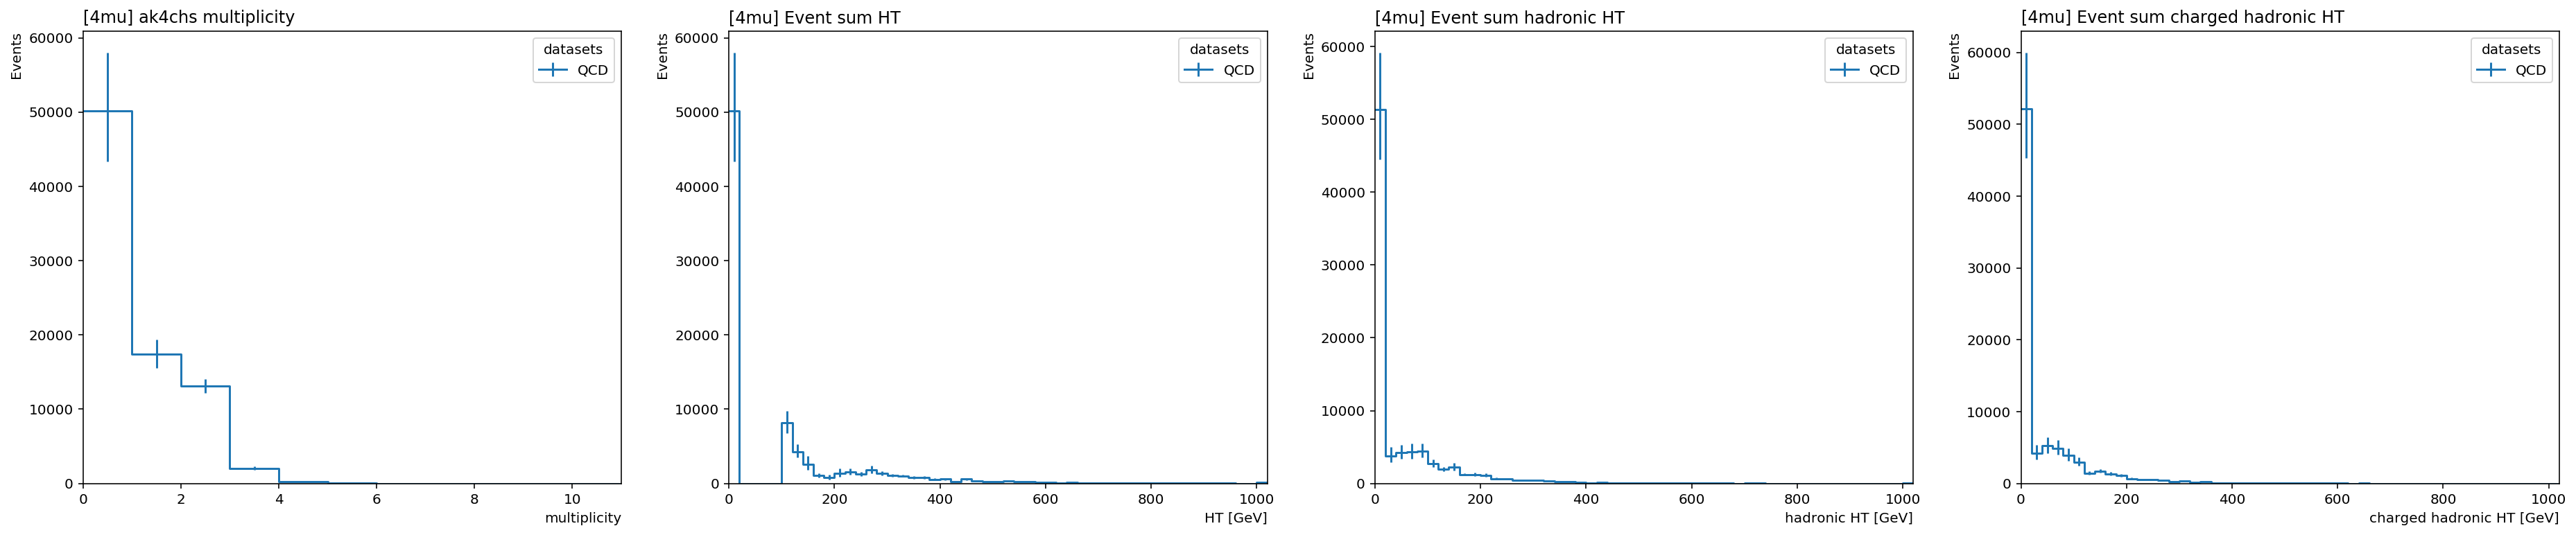

In [8]:
fig, axes = plt.subplots(1,4,figsize=(32,6))
hist.plot1d(output['multi_cat'].integrate('channel', '4mu'), overlay='cat', ax=axes[0], overflow='over', density=False)
# hist.plot1d(output['pt_cat'], overlay='cat', ax=axes[0][1], overflow='over', density=False)
# hist.plot1d(output['maxpt_cat'], overlay='cat', ax=axes[0][2], overflow='over', density=False)
hist.plot1d(output['ht_cat'].integrate('channel', '4mu'), overlay='cat', ax=axes[1], overflow='over', density=False)
hist.plot1d(output['hadht_cat'].integrate('channel', '4mu'), overlay='cat', ax=axes[2], overflow='over', density=False)
hist.plot1d(output['chahadht_cat'].integrate('channel', '4mu'), overlay='cat', ax=axes[3], overflow='over', density=False)

titles = [
    'ak4chs multiplicity',
#     'ak4chs $p_T$',
#     '3rd ak4chs $p_T$',
    'Event sum HT',
    'Event sum hadronic HT',
    'Event sum charged hadronic HT',
]
for i, ax in enumerate(axes.flat):
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title('[4mu] '+titles[i], ha='left', x=0)

In [9]:
from collections import defaultdict
res = defaultdict(dict)
h = output['multi_cat'].integrate('channel', '4mu')
for d in h.identifiers('cat'):
    h_ = h.integrate('cat', d)
    res[d]['total'] = h_.integrate('multi').values()[()]
    res[d]['1'] = h_.integrate('multi', slice(0,1)).values()[()]
    res[d]['2'] = h_.integrate('multi', slice(0,2)).values()[()]
import pandas as pd
df = pd.DataFrame(res).transpose()
df['eff@1'] = df['1']/df['total']
df['eff@2'] = df['2']/df['total']
df

,1,2,total,eff@1,eff@2
QCD,50184.562134,67560.050551,82926.510922,0.605169,0.814698


In [10]:
from collections import defaultdict
res = defaultdict(dict)
h = output['ht_cat'].integrate('channel', '4mu')
for d in h.identifiers('cat'):
    h_ = h.integrate('cat', d)
    res[d]['total'] = h_.integrate('ht').values()[()]
    res[d]['200'] = h_.integrate('ht', slice(0,200)).values()[()]
    res[d]['250'] = h_.integrate('ht', slice(0,250)).values()[()]
import pandas as pd
df = pd.DataFrame(res).transpose()
df['eff@200'] = df['200']/df['total']
df['eff@250'] = df['250']/df['total']
df

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:477: RuntimeWarning: Reducing along axis <Bin (name=ht) instance at 0x7f14a9e95ba8>: requested stop 250 between bin boundaries, no interpolation is performed
  RuntimeWarning)


,200,250,total,eff@200,eff@250
QCD,67108.246581,71223.597501,82771.930037,0.810761,0.86048


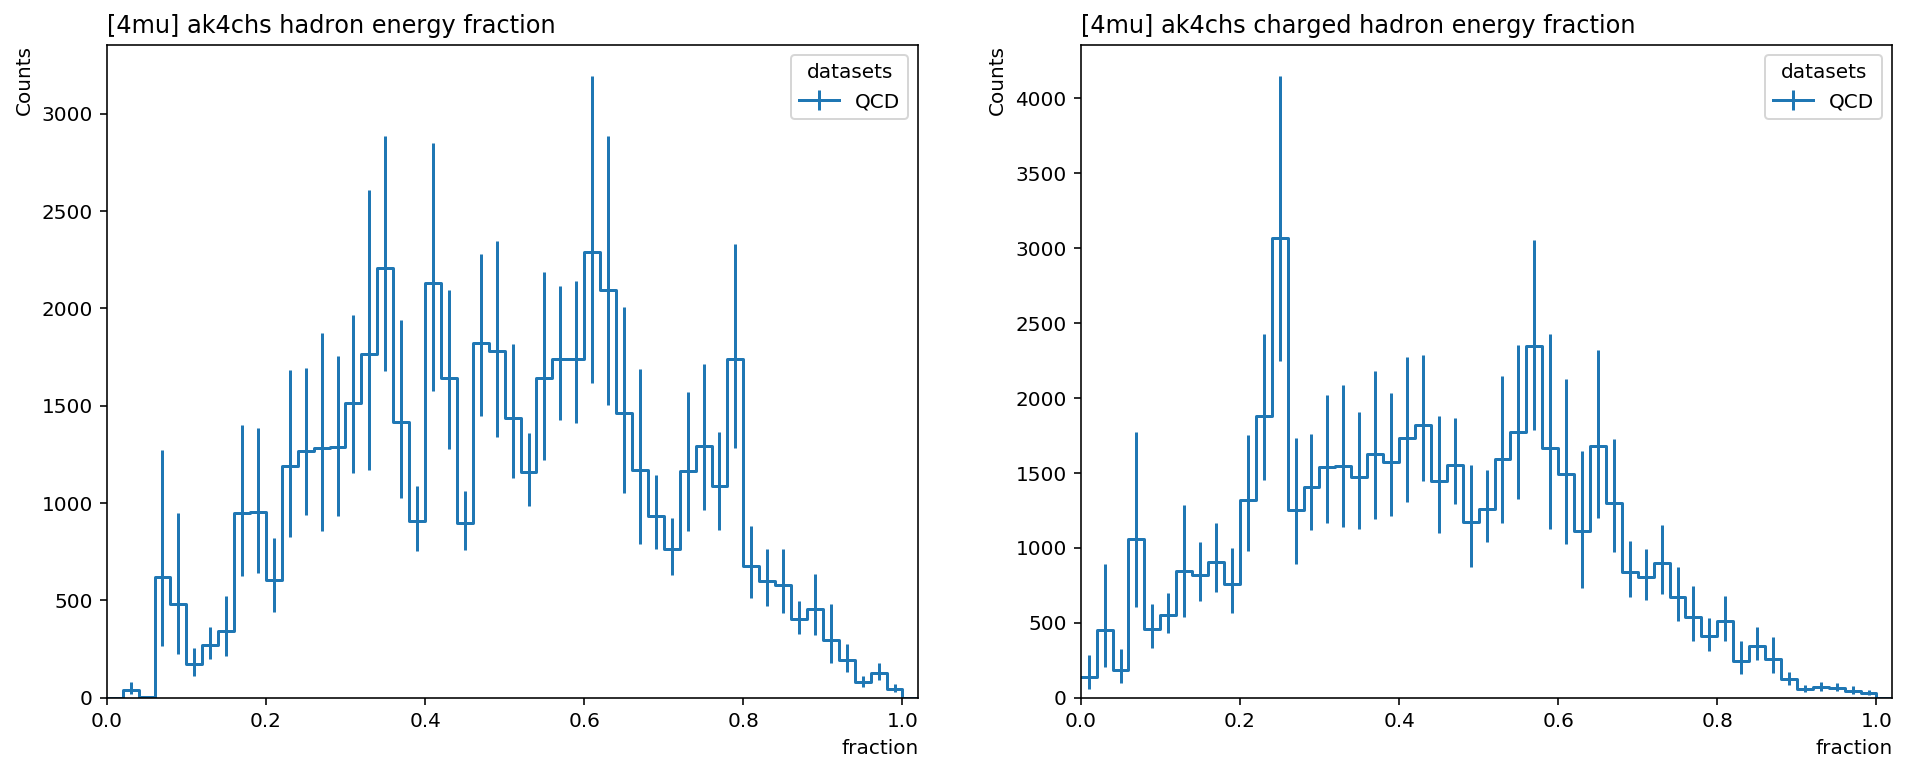

In [11]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['hadfrac_cat'].integrate('channel', '4mu'), overlay='cat', ax=axes[0], overflow='over', density=False)
hist.plot1d(output['chadfrac_cat'].integrate('channel', '4mu'), overlay='cat', ax=axes[1], overflow='over', density=False)

titles = [
    'ak4chs hadron energy fraction',
    'ak4chs charged hadron energy fraction',
]
for i, ax in enumerate(axes.flat):
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title('[4mu] '+titles[i], ha='left', x=0)

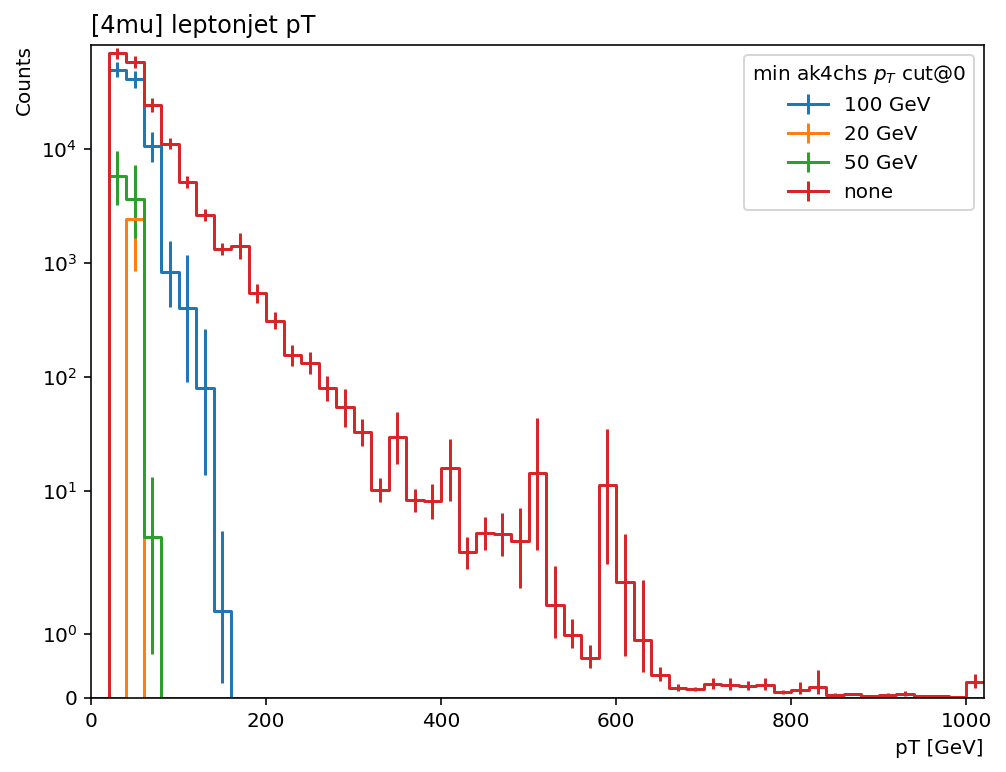

In [12]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
hist.plot1d(output['ljpt_cat'].integrate('channel', '4mu').integrate('cat'), overlay='minpt', ax=ax, overflow='over', density=False)

ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu] leptonjet pT', ha='left', x=0);

In [13]:
from collections import defaultdict
res = defaultdict(dict)
h = output['ak4chscut_cat'].integrate('channel', '4mu')
for d in h.identifiers('cat'):
    h_ = h.integrate('cat', d)
    for c in h_.identifiers('minpt'):
        hh_ = h_.integrate('minpt', c)
        res[d][str(c)] = hh_.integrate('cut', slice(1,2)).values()[()]/hh_.integrate('cut').values()[()]*100
        res[d]['total'] = hh_.integrate('cut').values()[()]

import pandas as pd
df = pd.DataFrame(res).transpose()

df_ = df[['total', '20 GeV', '50 GeV', '100 GeV']]
df_.columns = ['total', '20 GeV (%)', '50 GeV (%)', '100 GeV (%)']
df_

,total,20 GeV (%),50 GeV (%),100 GeV (%)
QCD,82926.510922,1.454682,5.617164,60.51691


- 2mu2e channel

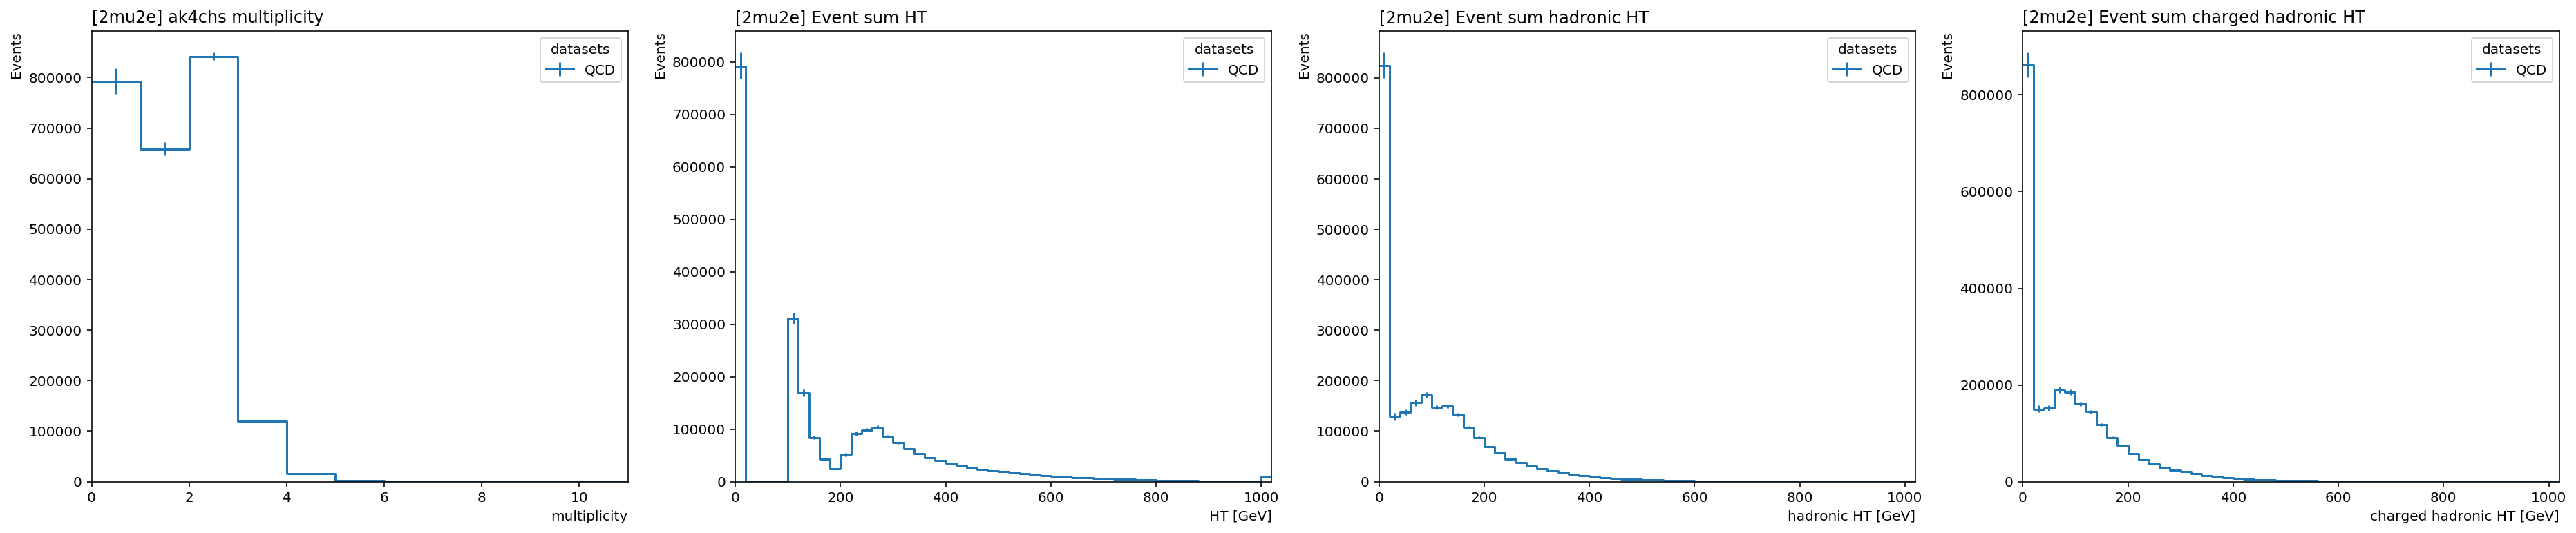

In [14]:
fig, axes = plt.subplots(1,4,figsize=(32,6))
hist.plot1d(output['multi_cat'].integrate('channel', '2mu2e'), overlay='cat', ax=axes[0], overflow='over', density=False)
# hist.plot1d(output['pt_cat'], overlay='cat', ax=axes[0][1], overflow='over', density=False)
# hist.plot1d(output['maxpt_cat'], overlay='cat', ax=axes[0][2], overflow='over', density=False)
hist.plot1d(output['ht_cat'].integrate('channel', '2mu2e'), overlay='cat', ax=axes[1], overflow='over', density=False)
hist.plot1d(output['hadht_cat'].integrate('channel', '2mu2e'), overlay='cat', ax=axes[2], overflow='over', density=False)
hist.plot1d(output['chahadht_cat'].integrate('channel', '2mu2e'), overlay='cat', ax=axes[3], overflow='over', density=False)

titles = [
    'ak4chs multiplicity',
#     'ak4chs $p_T$',
#     '3rd ak4chs $p_T$',
    'Event sum HT',
    'Event sum hadronic HT',
    'Event sum charged hadronic HT',
]
for i, ax in enumerate(axes.flat):
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title('[2mu2e] '+titles[i], ha='left', x=0)

In [15]:
from collections import defaultdict
res = defaultdict(dict)
h = output['multi_cat'].integrate('channel', '2mu2e')
for d in h.identifiers('cat'):
    h_ = h.integrate('cat', d)
    res[d]['total'] = h_.integrate('multi').values()[()]
    res[d]['1'] = h_.integrate('multi', slice(0,1)).values()[()]
    res[d]['2'] = h_.integrate('multi', slice(0,2)).values()[()]
import pandas as pd
df = pd.DataFrame(res).transpose()
df['eff@1'] = df['1']/df['total']
df['eff@2'] = df['2']/df['total']
df

,1,2,total,eff@1,eff@2
QCD,792351.479008,1.451220e+06,2.431157e+06,0.325915,0.596926


In [16]:
from collections import defaultdict
res = defaultdict(dict)
h = output['ht_cat'].integrate('channel', '2mu2e')
for d in h.identifiers('cat'):
    h_ = h.integrate('cat', d)
    res[d]['total'] = h_.integrate('ht').values()[()]
    res[d]['200'] = h_.integrate('ht', slice(0,200)).values()[()]
    res[d]['250'] = h_.integrate('ht', slice(0,250)).values()[()]
import pandas as pd
df = pd.DataFrame(res).transpose()
df['eff@200'] = df['200']/df['total']
df['eff@250'] = df['250']/df['total']
df

,200,250,total,eff@200,eff@250
QCD,1.424975e+06,1.666741e+06,2.421120e+06,0.58856,0.688417


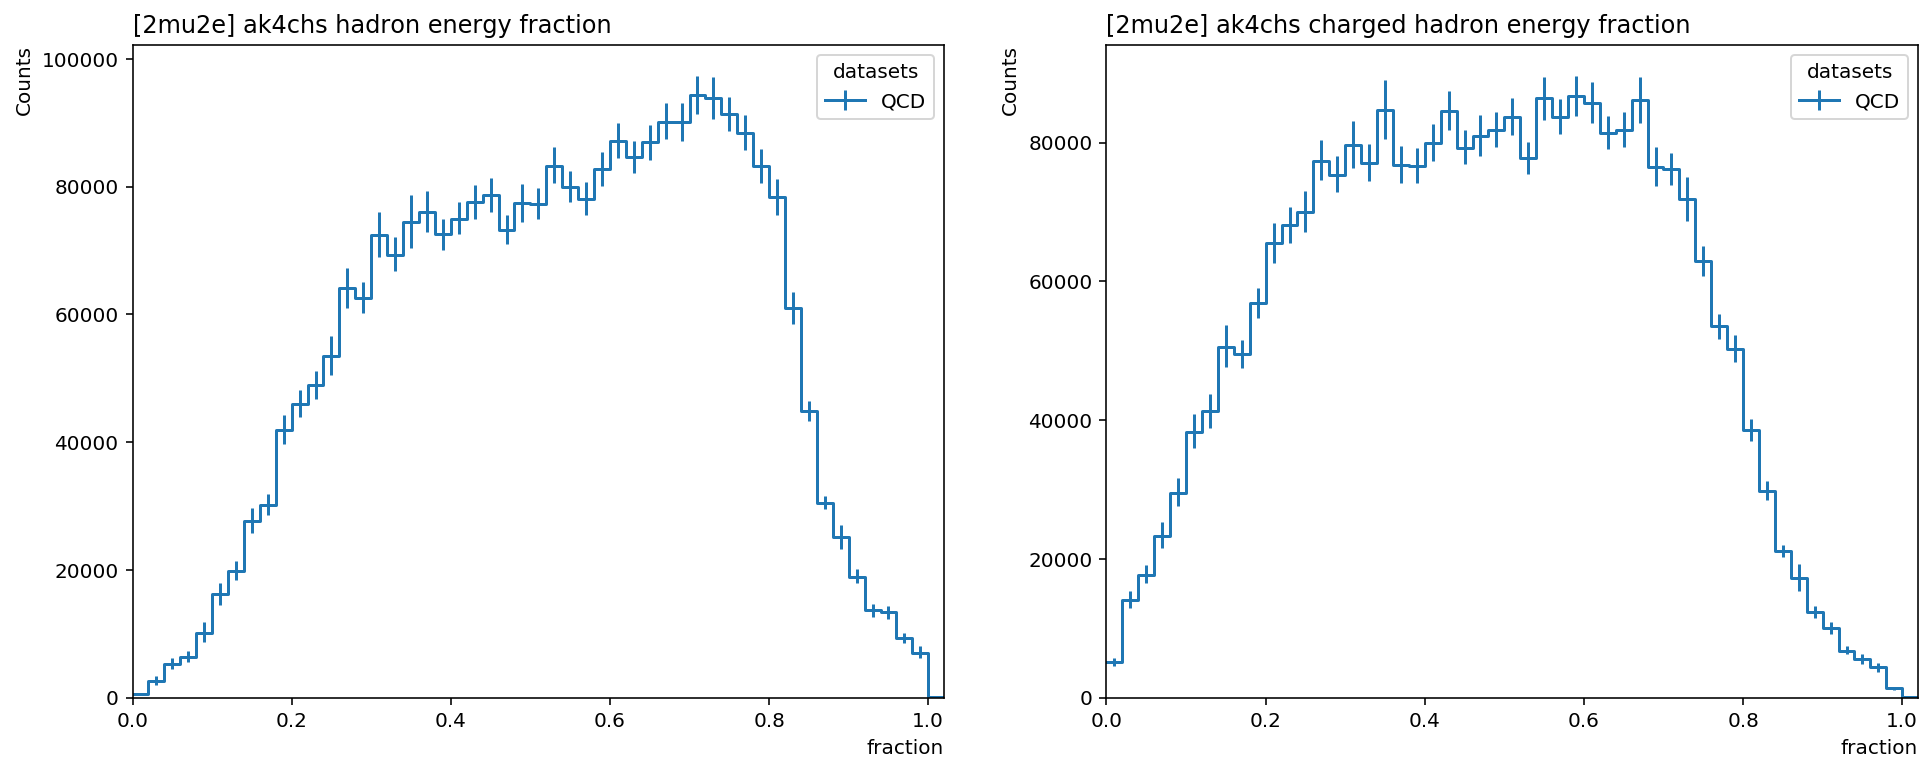

In [17]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['hadfrac_cat'].integrate('channel', '2mu2e'), overlay='cat', ax=axes[0], overflow='over', density=False)
hist.plot1d(output['chadfrac_cat'].integrate('channel', '2mu2e'), overlay='cat', ax=axes[1], overflow='over', density=False)

titles = [
    'ak4chs hadron energy fraction',
    'ak4chs charged hadron energy fraction',
]
for i, ax in enumerate(axes.flat):
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title('[2mu2e] '+titles[i], ha='left', x=0)

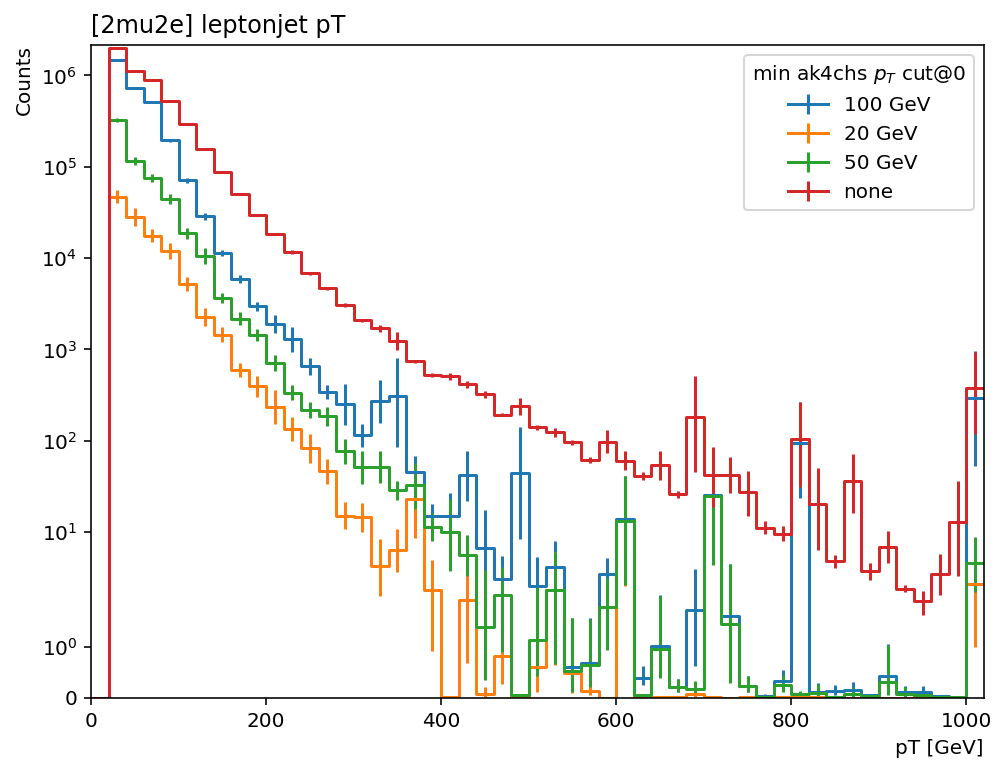

In [22]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
hist.plot1d(output['ljpt_cat'].integrate('channel', '2mu2e').integrate('cat'), overlay='minpt', ax=ax, overflow='over', density=False)

ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[2mu2e] leptonjet pT', ha='left', x=0);

In [23]:
from collections import defaultdict
res = defaultdict(dict)
h = output['ak4chscut_cat'].integrate('channel', '2mu2e')
for d in h.identifiers('cat'):
    h_ = h.integrate('cat', d)
    for c in h_.identifiers('minpt'):
        hh_ = h_.integrate('minpt', c)
        res[d][str(c)] = hh_.integrate('cut', slice(1,2)).values()[()]/hh_.integrate('cut').values()[()]*100
        res[d]['total'] = hh_.integrate('cut').values()[()]

import pandas as pd
df = pd.DataFrame(res).transpose()

df_ = df[['total', '20 GeV', '50 GeV', '100 GeV']]
df_.columns = ['total', '20 GeV (%)', '50 GeV (%)', '100 GeV (%)']
df_

,total,20 GeV (%),50 GeV (%),100 GeV (%)
QCD,2.431157e+06,2.363507,12.044801,59.692582


# apply leptonjet cleaning

In [ ]:
class leptonjetcleaningProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        channel_axis = hist.Cat('channel', 'channel')
        multi_axis = hist.Bin('multi', 'multiplicity', 20, 0, 20)
        pt_axis = hist.Bin('pt', 'pT', 50, 0, 300)
        self._accumulator = processor.dict_accumulator({
            'nak4': hist.Hist('Counts', dataset_axis, channel_axis, multi_axis),
            'ak4pt': hist.Hist('Counts', dataset_axis, channel_axis, pt_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset=df['dataset']
        
        ak4chs = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_p4'],
            px=df['akjet_p4.fCoordinates.fX'],
            py=df['akjet_p4.fCoordinates.fY'],
            pz=df['akjet_p4.fCoordinates.fZ'],
            energy=df['akjet_p4.fCoordinates.fT'],
            jetid=df['akjet_jetid'],
        )
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        twomujets = dileptonjets.ismutype.sum()==2
        leadinglj = dileptonjets[dileptonjets.pt.argmax()]
        subleadinglj = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        fourMuChannel = twomujets&(leadinglj.ismutype.flatten())&(subleadinglj.ismutype.flatten())
        
        onemujets = dileptonjets.ismutype.sum()==1
        twoMuTwoEChannel = onemujets&(leadinglj.ismutype.flatten()|subleadinglj.ismutype.flatten())
        ak4chs=ak4chs[twoleptonjets]
        
        ak4chs=ak4chs[(ak4chs.pt>20)&(ak4chs.jetid)]
        
#         ljmatchmask = dileptonjets.match(ak4chs, deltaRCut=0.4)
        ak4matchmask = ak4chs.match(dileptonjets, deltaRCut=0.4)
#         print((~ljmatchmask)[fourMuChannel].counts)
        
        output['nak4'].fill(dataset=dataset,
                            channel='4mu',
                            multi=(~ak4matchmask)[fourMuChannel].astype(int).sum()
                            )
        output['ak4pt'].fill(dataset=dataset,
                            channel='4mu',
                             pt=ak4chs[~ak4matchmask][fourMuChannel].pt.max()
                            )
        output['nak4'].fill(dataset=dataset,
                            channel='2mu2e',
                            multi=(~ak4matchmask)[twoMuTwoEChannel].astype(int).sum()
                            )
        output['ak4pt'].fill(dataset=dataset,
                            channel='2mu2e',
                             pt=ak4chs[~ak4matchmask][fourMuChannel].pt.max()
                            )
        return output
    def postprocess(self, accumulator):
        return accumulator

# overlapping btw. ak4chs and leptonjets

In [17]:
class overlapProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        channel_axis = hist.Cat('channel', 'channel')
        overlap_axis = hist.Bin('overlap', 'overlapped', 2, 0, 2)
        self._accumulator = processor.dict_accumulator({
            'overlapak4': hist.Hist('Counts', dataset_axis, channel_axis, overlap_axis),
            'overlaplj': hist.Hist('Counts', dataset_axis, channel_axis, overlap_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset=df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'].content,
                    py=df['gen_p4.fCoordinates.fY'].content,
                    pz=df['gen_p4.fCoordinates.fZ'].content,
                    energy=df['gen_p4.fCoordinates.fT'].content,
                    pid=df['gen_pid'].content,
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        ak4chs = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_p4'],
            px=df['akjet_p4.fCoordinates.fX'],
            py=df['akjet_p4.fCoordinates.fY'],
            pz=df['akjet_p4.fCoordinates.fZ'],
            energy=df['akjet_p4.fCoordinates.fT'],
            jetid=df['akjet_jetid'],
        )
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        if dileptonjets.size==0: return output
        twomujets = dileptonjets.ismutype.sum()==2
        leadinglj = dileptonjets[dileptonjets.pt.argmax()]
        subleadinglj = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        fourMuChannel = twomujets&(leadinglj.ismutype.flatten())&(subleadinglj.ismutype.flatten())
        
        onemujets = dileptonjets.ismutype.sum()==1
        twoMuTwoEChannel = onemujets&(leadinglj.ismutype.flatten()|subleadinglj.ismutype.flatten())
        ak4chs=ak4chs[twoleptonjets]
        ak4chs=ak4chs[(ak4chs.pt>20)&(ak4chs.jetid)]
        wgt=weight[twoleptonjets]
        
        ljmatchmask = dileptonjets.match(ak4chs, deltaRCut=0.4)
        ak4matchmask = ak4chs.match(dileptonjets, deltaRCut=0.4)
        
        output['overlapak4'].fill(dataset=dataset,
                                  channel='4mu',
                                  overlap=ak4matchmask[fourMuChannel].astype(int).flatten(),
                                  weight=(ak4chs.pt.ones_like()*wgt)[fourMuChannel].flatten(),
                                 )
        output['overlapak4'].fill(dataset=dataset,
                                  channel='2mu2e',
                                  overlap=ak4matchmask[twoMuTwoEChannel].astype(int).flatten(),
                                  weight=(ak4chs.pt.ones_like()*wgt)[twoMuTwoEChannel].flatten(),
                                 )
        output['overlaplj'].fill(dataset=dataset,
                                  channel='4mu',
                                  overlap=ljmatchmask[fourMuChannel].astype(int).flatten(),
                                 weight=(dileptonjets.pt.ones_like()*wgt)[fourMuChannel].flatten(),
                                 )
        output['overlaplj'].fill(dataset=dataset,
                                  channel='2mu2e',
                                  overlap=ljmatchmask[twoMuTwoEChannel].astype(int).flatten(),
                                 weight=(dileptonjets.pt.ones_like()*wgt)[twoMuTwoEChannel].flatten(),
                                 )
        return output
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        for k in origidentity:
            if not isinstance(accumulator[k], hist.Hist): continue
            accumulator[k].scale(scales, axis='dataset') # scale
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping) # cat grouping
        return accumulator

In [23]:
output = processor.run_uproot_job(datasets,
                                  treename="ffNtuplizer/ffNtuple",
                                  processor_instance=overlapProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 936/936 [02:22<00:00,  6.55items/s]


In [24]:
from collections import defaultdict
import pandas as pd

res = defaultdict(dict)
h = output['overlapak4_cat'].integrate('channel', '4mu')
for d in h.identifiers('cat'):
    h_ = h.integrate('cat', d)
    res[d]['total'] = h_.integrate('overlap').values()[()]
    res[d]['overlap ratio %'] = h_.integrate('overlap', slice(1,2)).values()[()]/h_.integrate('overlap').values()[()]*100
df = pd.DataFrame(res).transpose()
print('AK4CHS')
display(df)

res = defaultdict(dict)
h = output['overlaplj_cat'].integrate('channel', '4mu')
for d in h.identifiers('cat'):
    h_ = h.integrate('cat', d)
    res[d]['total'] = h_.integrate('overlap').values()[()]
    res[d]['overlap ratio %'] = h_.integrate('overlap', slice(1,2)).values()[()]/h_.integrate('overlap').values()[()]*100
df = pd.DataFrame(res).transpose()
print('leptonjet')
display(df)

AK4CHS


,overlap ratio %,total
QCD,29.309496,548638.33687


leptonjet


,overlap ratio %,total
QCD,92.70681,173172.041295


In [25]:
from collections import defaultdict
import pandas as pd

res = defaultdict(dict)
h = output['overlapak4_cat'].integrate('channel', '2mu2e')
for d in h.identifiers('cat'):
    h_ = h.integrate('cat', d)
    res[d]['total'] = h_.integrate('overlap').values()[()]
    res[d]['overlap ratio %'] = h_.integrate('overlap', slice(1,2)).values()[()]/h_.integrate('overlap').values()[()]*100
df = pd.DataFrame(res).transpose()
print('AK4CHS')
display(df)

res = defaultdict(dict)
h = output['overlaplj_cat'].integrate('channel', '2mu2e')
for d in h.identifiers('cat'):
    h_ = h.integrate('cat', d)
    res[d]['total'] = h_.integrate('overlap').values()[()]
    res[d]['overlap ratio %'] = h_.integrate('overlap', slice(1,2)).values()[()]/h_.integrate('overlap').values()[()]*100
df = pd.DataFrame(res).transpose()
print('leptonjet')
display(df)

AK4CHS


,overlap ratio %,total
QCD,31.538626,1.575931e+07


leptonjet


,overlap ratio %,total
QCD,95.340775,5.198878e+06
